# ** Vehicle Detection and Tacking Project **

The steps of this project are the following:

* Perform a Histogram of Oriented Gradients (HOG) feature extraction on a labeled training set of images and train a classifier Linear SVM classifier
* Apply a color transform and append binned color features, as well as histograms of color, to the HOG feature vector. 
* Normalize features and randomize a selection for training and testing.
* Implement a sliding-window technique and use trained classifier to search for vehicles in images.
* Run a pipeline on a video stream (start with the test_video.mp4 and later implement on full project_video.mp4) and create a heat map of recurring detections frame by frame to reject outliers and follow detected vehicles.
* Estimate a bounding box for vehicles detected.


# Load Libraries

In [1]:
import cv2
import glob
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

from sklearn.preprocessing import StandardScaler
from sklearn.cross_validation import train_test_split
from skimage.feature import hog
from skimage.measure import label, regionprops

from sklearn.svm import LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import pickle
from sklearn.externals import joblib
from scipy.ndimage.measurements import label    

%matplotlib inline

import os
os.chdir("D:/Vehicle-Detection-and-Tracking-Project") 

# Data Exploration

In [2]:
# Read in cars and notcars
cars = []
notcars = []

cars_path = glob.glob('data/vehicles/*/*.png')
notcars_path = glob.glob('data/non-vehicles/*/*.png')   

for image in cars_path:
    cars.append(image)
    
for image in notcars_path:
    notcars.append(image)
    
print ('Number of vehicles images found : {}'.format(len(cars))) 
print ('Number of non-vehicles images found : {}'.format(len(notcars))) 

Number of vehicles images found : 8792
Number of non-vehicles images found : 8968


# Data Visualisation

In [3]:
# Helper function for multiple image visualisation
# source  : Udacity  Q& A
def visualise(fig,row,cols,imgs,titles):
    for i, img in enumerate(imgs):
        plt.subplot(row,cols,i+1)
        plt.title(i+1)
        imgs_dims = len(img.shape)
        if imgs_dims <3:
            plt.imshow(img,cmap='hot')
            plt.title(titles[i])
        else:
            plt.imshow(img)
            plt.title(titles[i])
        plt.axis('off')

Your function returned a count of 8792  cars and 8968  non-cars
of size:  (64, 64, 3)  and data type: float32
car_image  data/vehicles\KITTI_extracted\3139.png 5201 (64, 64, 3)
notcar_image  data/non-vehicles\GTI\image1118.png 5201 (64, 64, 3)


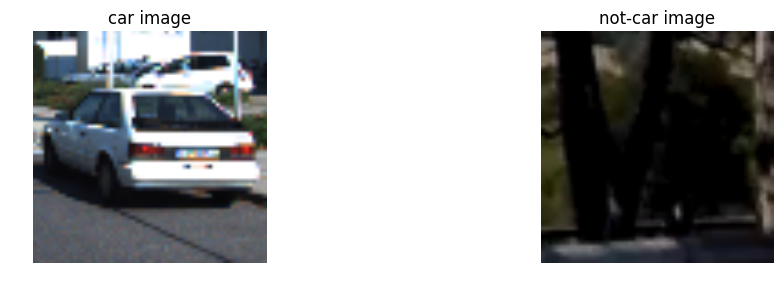

In [4]:
def data_look(car_list, notcar_list):
    data_dict = {}
    # Define a key in data_dict "n_cars" and store the number of car images
    data_dict["n_cars"] = len(car_list)
    # Define a key "n_notcars" and store the number of notcar images
    data_dict["n_notcars"] = len(notcar_list)
    # Read in a test image, either car or notcar
    example_img = mpimg.imread(car_list[0])
    # Define a key "image_shape" and store the test image shape 3-tuple
    data_dict["image_shape"] = example_img.shape
    # Define a key "data_type" and store the data type of the test image.
    data_dict["data_type"] = example_img.dtype
    # Return data_dict
    return data_dict


data_info = data_look(cars, notcars)

print('Your function returned a count of', 
      data_info["n_cars"], ' cars and', 
      data_info["n_notcars"], ' non-cars')
print('of size: ',data_info["image_shape"], ' and data type:', 
      data_info["data_type"])

# Plot sample images with random car / not-car indices  
seed = np.random.seed(370)
car_ind = np.random.randint(0, len(cars))
notcar_ind = np.random.randint(0, len(notcars))
    
# Read in car / not-car images
car_image = mpimg.imread(cars[car_ind])
print('car_image ', cars[car_ind] ,car_ind, car_image.shape)

notcar_image = mpimg.imread(notcars[notcar_ind])
print('notcar_image ', notcars[car_ind],car_ind, notcar_image.shape)

images = [car_image,notcar_image]
titles = ['car image','not-car image']
fig = plt.figure(figsize=(12,3))
visualise(fig,1,2,images,titles)
# plt.subplots_adjust(left=0., right=1.5, top=0.7, bottom=0.)
plt.savefig('output_images/car_notcar_image.png')

# Global Parameters

In [5]:
## Settled with these values for global parameters

color_space = 'YCrCb' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 9  # HOG orientations
pix_per_cell = 8 # HOG pixels per cell
cell_per_block = 2 # HOG cells per block
hog_channel = "ALL" # Can be 0, 1, 2, or "ALL"  
spatial_size = (64,64) # 32,32)
hist_bins = 32  #64    # Number of histogram bins
spatial_feat = True # Spatial features on or off
hist_feat = True # Histogram features on or off
hog_feat = True # HOG features on or off
y_start_stop = [390,600]
x_start_stop = [630,1280]      

# Feature Vector Extract Functions

# Color Histogram Features

In [6]:
# Define a function to compute color histogram features

def color_hist(img, nbins=32):                    
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:, :, 0], bins=nbins)
    channel2_hist = np.histogram(img[:, :, 1], bins=nbins)
    channel3_hist = np.histogram(img[:, :, 2], bins=nbins)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    return hist_features


# Histogram of Oriented Gradients (HOG)

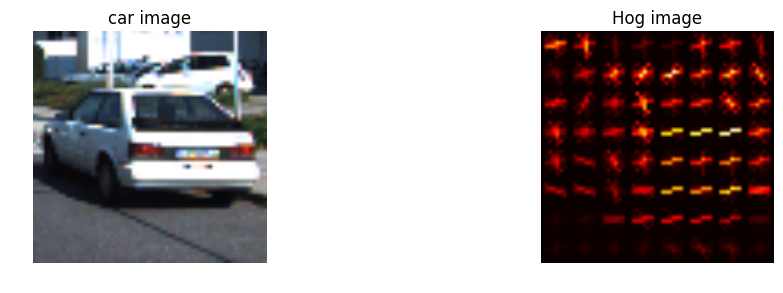

In [7]:
# Define a function to return HOG features and visualization
def get_hog_features(img, orient, pix_per_cell, cell_per_block,
                     vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient,
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block),
                                  transform_sqrt=True,
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:
        features = hog(img, orientations=orient,
                       pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block),
                       transform_sqrt=True,
                       visualise=vis, feature_vector=feature_vec)
        return features
    

# Read in the image
sample_car_image = mpimg.imread(cars[car_ind])
gray = cv2.cvtColor(np.copy(sample_car_image), cv2.COLOR_RGB2GRAY) # change to gray image

# Call our function with vis=True to see an image output
features, hog_image = get_hog_features(gray, orient, 
                        pix_per_cell, cell_per_block, 
                        vis=True, feature_vec=False)


images = [sample_car_image,hog_image]
titles = ['car image','Hog image']
fig = plt.figure(figsize=(12,3))
visualise(fig,1,2,images,titles)
# plt.subplots_adjust(left=0., right=1.5, top=0.7, bottom=0.)
plt.savefig('output_images/Hog_Visualisation.png')


# Binned Color Features

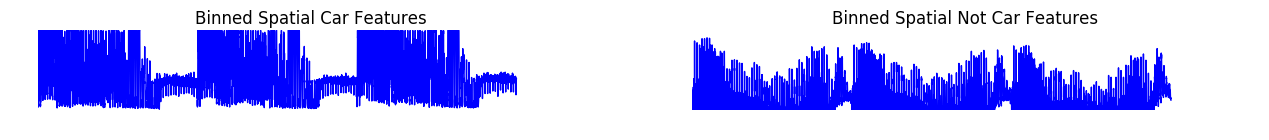

In [8]:
# Define a function to compute binned color features
# Use cv2.resize().ravel() to create the feature vector
def bin_spatial(img, size=(32, 32)):
    color1 = cv2.resize(img[:,:,0],size).ravel()
    color2 = cv2.resize(img[:,:,1],size).ravel()
    color3 = cv2.resize(img[:,:,2],size).ravel()
    # Return the feature vector
    return np.hstack((color1,color2,color3))

# plot bin spatial feature
fig = plt.figure()
plt.subplot(121)
feature_vector = bin_spatial(car_image,size=(64,64))
plt.plot(feature_vector)
plt.title('Binned Spatial Car Features')
plt.axis('off')
plt.subplot(122)
feature_vector = bin_spatial(notcar_image,size=(64,64))
plt.plot(feature_vector)
plt.title('Binned Spatial Not Car Features')
plt.axis('off')
plt.subplots_adjust(left=0., right=2, top=0.3, bottom=0.1)
# Save images
plt.savefig('output_images/bin_spatial.png')    



# Single Image Features Extract Function

In [9]:
# Define a function to extract features from a single image
# Have this function call bin_spatial() and color_hist()
def single_img_features(img, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient = 9, pix_per_cell = 8, 
                        cell_per_block = 2, hog_channel = 0,
                        spatial_feat = True, hist_feat = True,
                        hog_feat = True, vis = False):
    # 1) Create a list to append feature vectors to
    img_features = []
    # Iterate through the list of images
    # 2) apply color conversion if other than 'RGB'
    if color_space != 'RGB':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    else: feature_image = np.copy(img)     
    # 3) Compute spatial features if flag is set
    if spatial_feat == True:
        # Apply bin_spatial() to get spatial color features
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        img_features.append(spatial_features)
        
    # 4) Compute histogram features if flag is set   
    if hist_feat == True:
        # Apply bin_spatial() to get spatial color features
        hist_features = color_hist(feature_image, nbins=hist_bins)
        img_features.append(hist_features)

    # 5) Compute HOG features if flag is set        
    if hog_feat == True:
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                                     orient, pix_per_cell, cell_per_block, 
                                                     vis=False, feature_vec=True))
            hog_features = np.concatenate(hog_features)
        else:
            if vis == True:
                hog_features, hog_image = get_hog_features(feature_image[:,:,hog_channel], 
                                                           orient, pix_per_cell, cell_per_block, 
                                                           vis=True, feature_vec = True)
            else: 
                hog_features = get_hog_features(feature_image[:,:,hog_channel], 
                                                           orient, pix_per_cell, cell_per_block, 
                                                           vis=False, feature_vec = True)
        img_features.append(hog_features)
    
    if vis == True:
        return np.concatenate(img_features), hog_image
    else:
        return np.concatenate(img_features)

# Extract features using Single image function

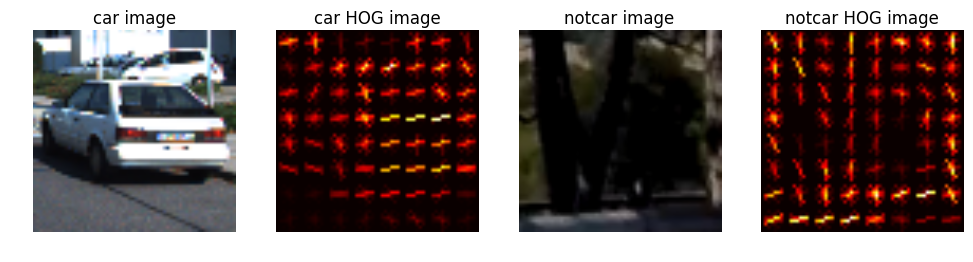

In [10]:
car_features,car_hot_image = single_img_features (np.copy(car_image), color_space=color_space, spatial_size=spatial_size,
                        hist_bins=hist_bins, orient=orient,
                        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True,vis = True)

notcar_features,notcar_hot_image = single_img_features(np.copy(notcar_image), color_space=color_space, spatial_size=spatial_size,
                        hist_bins=hist_bins, orient=orient,pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True,vis = True)


images = [car_image,car_hot_image,notcar_image,notcar_hot_image]
titles = ['car image','car HOG image','notcar image','notcar HOG image']
fig = plt.figure(figsize=(12,3))
visualise(fig,1,4,images,titles)
# Save images
plt.savefig('output_images/extract_single_image_feature.png') 


# Function to extract features vector from a List of Images


In [11]:
# Define a function to extract features from a list of images
# Have this function call bin_spatial() and color_hist()
def extract_features(imgs, color_space='RGB', spatial_size=(32, 32),
                     hist_bins=32, orient=9,
                     pix_per_cell=8, cell_per_block=2, hog_channel=0,
                     spatial_feat=True, hist_feat=True,hog_feat=True,viz=False):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        file_features = []
         # Read in each one by one
        image = mpimg.imread(file, format='PNG')   
        # 2) apply color conversion if other than 'RGB'
        if color_space != 'RGB':
            if color_space == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif color_space == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif color_space == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif color_space == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif color_space == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        else:
            feature_image = np.copy(image)
        
        # 3) Compute spatial features if flag is set 
        if spatial_feat == True:
            spatial_features = bin_spatial(feature_image, size=spatial_size)
            file_features.append(spatial_features)
            
        # 4) Compute histogram features if flag is set             
        if hist_feat == True:
            # Apply color_hist()
            hist_features = color_hist(feature_image, nbins=hist_bins)
            file_features.append(hist_features)
            
        # 5) Compute HOG features if flag is set             
        if hog_feat == True:
            # Call get_hog_features() with vis=False, feature_vec=True
            if viz == True:
                if hog_channel == 'ALL':
                    hog_features = []
                    for channel in range(feature_image.shape[2]):
                        hog_feature, hog_image = get_hog_features(feature_image[:, :, channel],
                                                                  orient, pix_per_cell, cell_per_block,
                                                                  vis=True, feature_vec=True)
                        hog_features.append(hog_feature)
                    hog_features = np.ravel(hog_features)
                else:
                    hog_features, hog_image = get_hog_features(feature_image[:, :, hog_channel], orient,
                                                               pix_per_cell, cell_per_block, vis=True, feature_vec=True)
            else:
                if hog_channel == 'ALL':
                    hog_features = []
                    for channel in range(feature_image.shape[2]):
                        hog_feature = get_hog_features(feature_image[:, :, channel],
                                                       orient, pix_per_cell, cell_per_block,
                                                       vis=False, feature_vec=True)
                        hog_features.append(hog_feature)
                    hog_features = np.ravel(hog_features)
                else:
                    hog_features = get_hog_features(feature_image[:, :, hog_channel], orient,
                                                    pix_per_cell, cell_per_block, vis=False, feature_vec=True)
            # Append the new feature vector to the features list
            file_features.append(hog_features)
        features.append(np.concatenate(file_features))
    # Return list of feature vectors
    return features

# Combine and extract features vector for training

In [12]:
car_features = extract_features(cars, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)
notcar_features = extract_features(notcars, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat,hog_feat=hog_feat)

# Create an array stack of feature vectors
X = np.vstack((car_features, notcar_features)).astype(np.float64)                        


# Normalize Features

In [13]:
# Fit a per-column scaler
X_scaler = StandardScaler().fit(X)
pickle.dump(X_scaler,open("X_scaler.pkl","wb"))
print ("X_scaler saved successfully")

# Apply the scaler to X
scaled_X = X_scaler.transform(X)

# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))

# print ("y shape :",y.shape)

# Split up data into randomized training and test sets
random_state = np.random.randint(0,100)
X_train, X_test, y_train, y_test = train_test_split(
    scaled_X, y, test_size=0.1, random_state=random_state)

# adapted from Udacity's Q & A

print('Using:',orient,'orientations',pix_per_cell,
    'pixels per cell and', cell_per_block,'cells per block')
print('Feature vector length:', len(X_train[0]))

print ("X_train shape :", X_train.shape)
print ("scaled_X shape :",scaled_X.shape)

X_scaler saved successfully
Using: 9 orientations 8 pixels per cell and 2 cells per block
Feature vector length: 17676
X_train shape : (15984, 17676)
scaled_X shape : (17760, 17676)


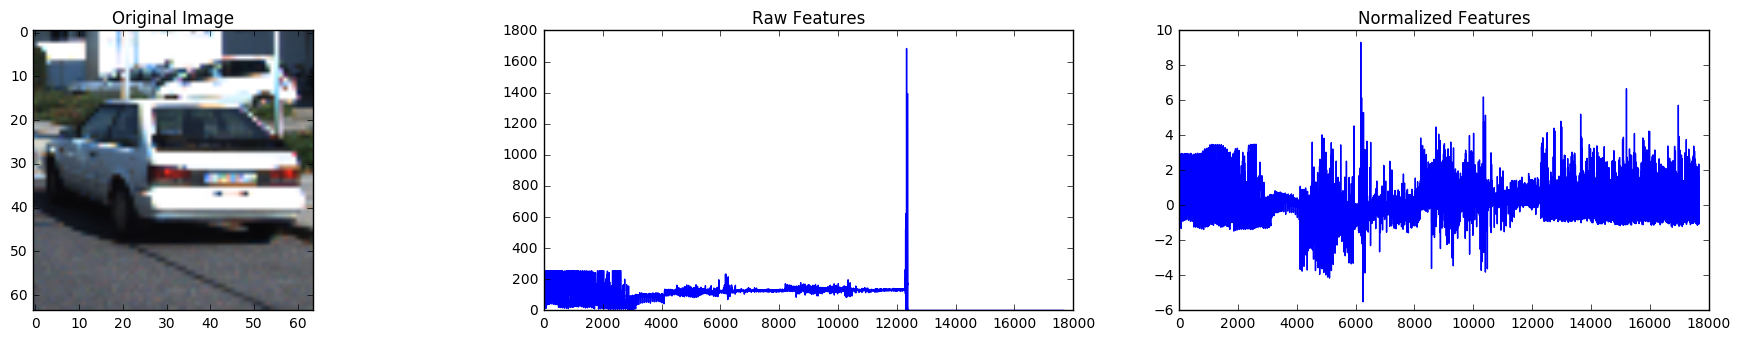

In [14]:
# Plot an example of raw and scaled features image

fig = plt.figure(figsize=(12,4))
plt.subplot(131)
plt.imshow(mpimg.imread(cars[car_ind]))
plt.title('Original Image')
plt.subplot(132)
plt.plot(X[car_ind])
plt.title('Raw Features')
plt.subplot(133)
plt.plot(scaled_X[car_ind])
plt.title('Normalized Features')
plt.subplots_adjust(left=0., right=1.5, top=0.7, bottom=0.)
# Save images
plt.savefig('output_images/Normalized_Features_image.png') 


# Classifier function

In [15]:
# Use a Classifier

def classifier(clf ='svc'):
    if clf == 'svc':
        svc = LinearSVC()  # LinearSVC(c=1.0)
        svc.fit(X_train, y_train)
        # Check the score of the SVC
        score = round(svc.score(X_test, y_test), 4)
        filename = "svc_model.pkl"
        joblib.dump(svc, filename)
        print ("SVC saved successfully")
        print('Test Accuracy of SVC = ', score)
        return svc,score    
    elif clf =='random_forest':
        random_forest = RandomForestClassifier(n_estimators=130,criterion="entropy") 
        random_forest.fit(X_train, y_train)
        score = round(random_forest.score(X_test, y_test), 4)
        filename = "rf_model.pkl"
        joblib.dump(random_forest, filename)
        print ("rf saved successfully")
        return random_forest,score    
        
    elif clf == 'knn':
        knn = KNeighborsClassifier(n_neighbors = 9)
        knn.fit(X_train, y_train)
        score = round(knn.score(X_test, y_test), 4)
        filename = "knn_model.pkl"
        joblib.dump(knn, filename)
        print ("knn saved successfully")
        return knn,score   
    elif clf=='vehicle_model':
        model =  vehicle_model()
        model.compile(optimizer='rmsprop',loss='binary_crossentropy', metrics=['accuracy'])
        model  = model.fit(X_train,y_train,validation_data= (X_test, y_test),nb_epoch = 10)
        filename = "NN_model.pkl"
        joblib.dump(vehicle_model, filename)
        print ("NN saved successfully")
        return vehicle_model

clf,score = classifier ('svc') #('random_forest') 

# clf = classifier ('vehicle_model')  # for Keras model

SVC saved successfully
Test Accuracy of SVC =  0.9932


In [16]:
print (clf,score)

LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0) 0.9932


# Sliding Window -Search window Functions

In [17]:
# Codes adapted form Udacity Lessons

# draw_boxes function 
def draw_boxes(img, bboxes, color=(255, 255, 255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy
    
    
# Define a function that takes an image,
# start and stop positions in both x and y, 
# window size (x and y dimensions),  
# and overlap fraction (for both x and y)
def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None], 
                    xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
    # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
    # Compute the span of the region to be searched    
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    # Compute the number of pixels per step in x/y
    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
    # Compute the number of windows in x/y
    nx_windows = np.int(xspan/nx_pix_per_step) - 1
    ny_windows = np.int(yspan/ny_pix_per_step) - 1
    # Initialize a list to append window positions to
    window_list = []
    # Loop through finding x and y window positions
    # Note: you could vectorize this step, but in practice
    # you'll be considering windows one by one with your
    # classifier, so looping makes sense
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            # Calculate window position
            startx = xs*nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys*ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]
            # Append window position to list
            window_list.append(((startx, starty), (endx, endy)))
    # Return the list of windows
    return window_list


# Apply slide_window to determine xy_window=(96,96)(128,128) bouandaries

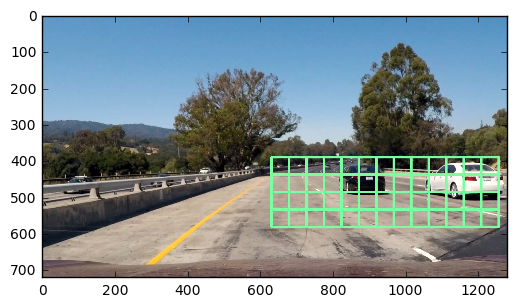

In [18]:
# xy_window=(96,96)

image = mpimg.imread('test_images/test1.jpg',format='PNG')
    
windows = slide_window(image, x_start_stop=x_start_stop, y_start_stop=y_start_stop, 
                    xy_window=(96,96), xy_overlap=(0.5, 0.5))
                       
window_img = draw_boxes(image, windows, color=(120, 255,160), thick=6)                    
plt.imshow(window_img)
# Save images
plt.savefig('output_images/slide_window_96x96.png') 

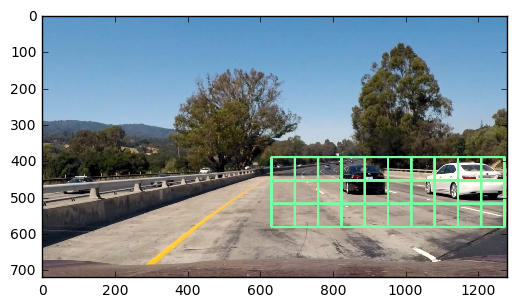

In [19]:
# xy_window=(128,128)

img = mpimg.imread('test_images/test1.jpg',format='PNG')
   
windows = slide_window(image, x_start_stop=x_start_stop, y_start_stop=y_start_stop, 
                    xy_window=(128,128), xy_overlap=(0.5, 0.5))
                       
window_img = draw_boxes(image, windows, color=(120, 255,160), thick=6)                    
plt.imshow(window_img)
# Save images
plt.savefig('output_images/slide_window_128x128.png')

# Search and Classify function

In [20]:
 # Code adapted form Udacity Lessons

# Define a function will pass an image
# and the list of windows to be searched (output of slide_windows())
def search_windows(img, windows, clf, scaler, color_space='RGB',
                   spatial_size=(32, 32), hist_bins=32,
                   hist_range=(0, 256), orient=9,
                   pix_per_cell=8, cell_per_block=2,
                   hog_channel=0, spatial_feat=True,
                   hist_feat=True, hog_feat=True):
    """Returns a list of windows the classifier has predicted contain cars."""
    # 1) Create an empty list to receive positive detection windows
    on_windows = []
    # 2) Iterate over all windows in the list
    for window in windows:
        # 3) Extract the test window from original image
        test_img = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64))
        # 4) Extract features for that window using single_img_features()
        features = single_img_features(test_img, color_space=color_space,
                                       spatial_size=spatial_size, hist_bins=hist_bins,
                                       orient=orient, pix_per_cell=pix_per_cell,
                                       cell_per_block=cell_per_block,
                                       hog_channel=hog_channel, spatial_feat=spatial_feat,
                                       hist_feat=hist_feat, hog_feat=hog_feat)
        # 5) Scale extracted features to be fed to classifier
        test_features = scaler.transform(np.array(features).reshape(1, -1))
        # 6) Predict using your classifier
        prediction = clf.predict(test_features)
        # 7) If positive (prediction == 1) then save the window
        if prediction == 1:   
            on_windows.append(window)
    # 8) Return windows for positive detections
    return on_windows


# Multiple Detections and Bounding Box Test

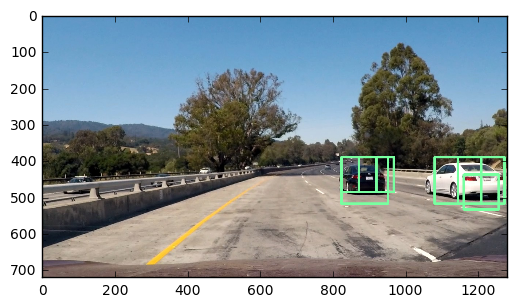

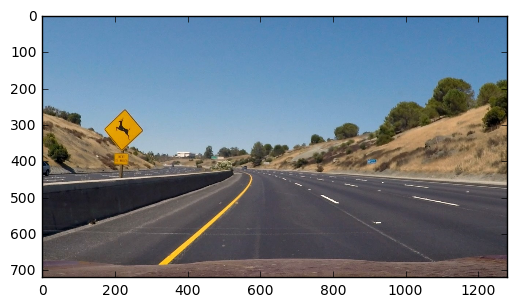

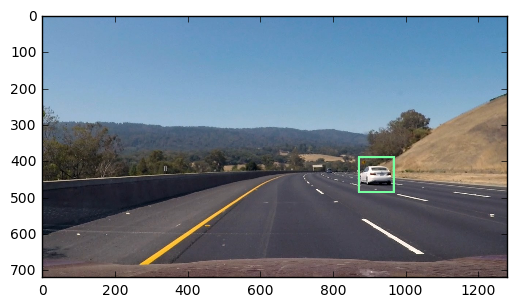

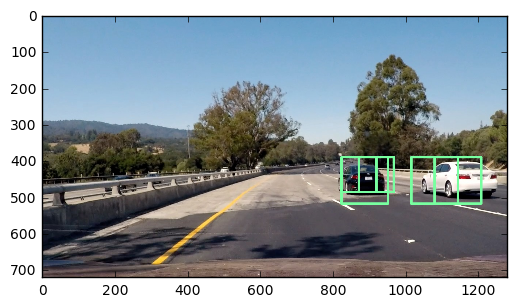

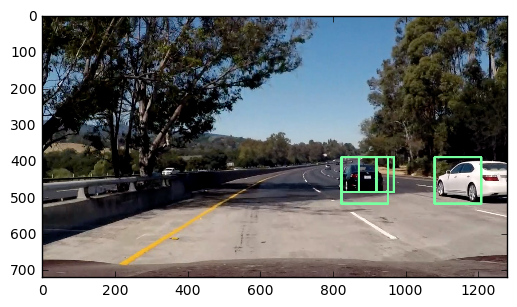

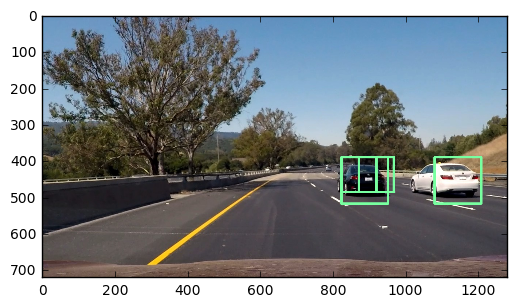

In [21]:
xy_windows = [(128,128),(96,96)] 
xy_overlaps = [(0.5,0.5)]  #, (0.75, 0.75)]
clf = joblib.load("svc_model.pkl")

def test_bounding_boxes(image):
        windows = []
        for i in range(len(xy_windows)):
            windows += slide_window(image, x_start_stop= x_start_stop, y_start_stop=y_start_stop, 
                        xy_window=xy_windows[i], xy_overlap= (0.50, 0.50))  

        # Return all the windows the classifier has predicted contain car(s) ('positive windows').
        hot_windows = search_windows(image, windows,clf, X_scaler, color_space=color_space, 
                                    spatial_size=spatial_size, hist_bins=hist_bins, 
                                    orient=orient, pix_per_cell=pix_per_cell, 
                                    cell_per_block=cell_per_block, 
                                    hog_channel=hog_channel, spatial_feat=spatial_feat, 
                                    hist_feat=hist_feat, hog_feat=hog_feat)                       

        # Draw bounding boxes around the windows that the classifier predicted has cars in them
        window_img =  draw_boxes(image, hot_windows, color=(120,255,160), thick=6)                    
        plt.figure()
        plt.imshow(window_img)    
    
for file in glob.glob('test_images/*'):
    image = mpimg.imread(file, format='PNG')
    test_bounding_boxes(image)
    # Save images
    plt.savefig('output_images/multiple_detections.png')

# Heat-map and False Positives

In [22]:
# Code adapted form Udacity Lessons
    
def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap# Iterate through list of bboxes
    
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

# put bounding boxes around the labeled regions
def draw_labeled_bboxes(img, labels):
    #make a copy of the image
    draw_img = np.copy(img)
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(draw_img, bbox[0], bbox[1], (120,255,160), 6)
    # Return the image
    return draw_img

# Visualiaze heatmap & Save Hot-Windows


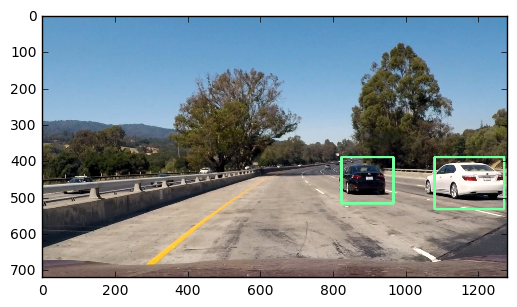

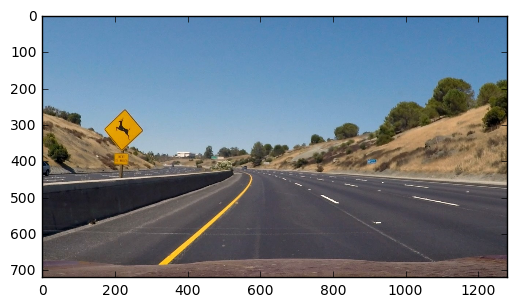

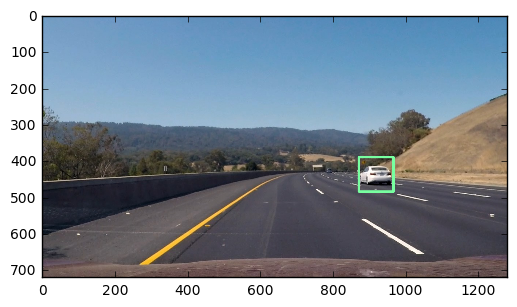

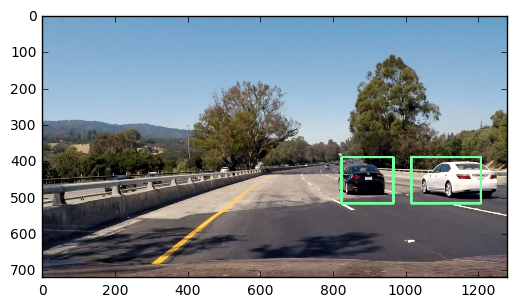

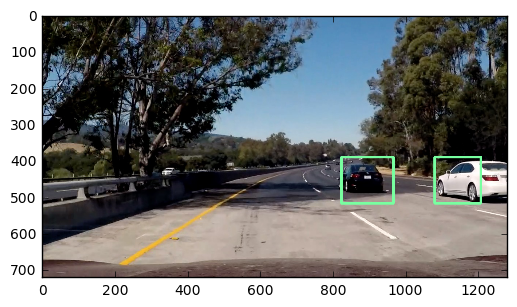

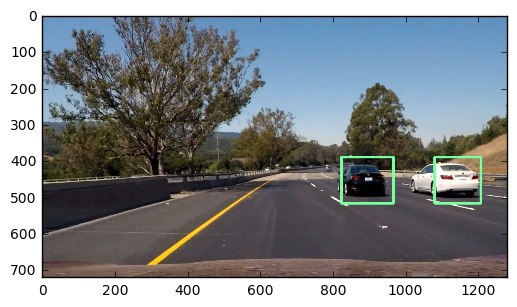

In [23]:
# clf = joblib.load('svc_model.pkl') 

for file in glob.glob('test_images/*'):
    image = mpimg.imread(file, format='PNG')
    windows = []
    for i in range(len(xy_windows)):
        windows += slide_window(image, x_start_stop=x_start_stop, y_start_stop=y_start_stop, 
                    xy_window=xy_windows[i], xy_overlap=(0.50, 0.50)) 
    hot_windows = search_windows(image, windows, clf, X_scaler, color_space=color_space, 
                                spatial_size=spatial_size, hist_bins=hist_bins, 
                                orient=orient, pix_per_cell=pix_per_cell, 
                                cell_per_block=cell_per_block, 
                                hog_channel=hog_channel, spatial_feat=spatial_feat, 
                                hist_feat=hist_feat, hog_feat=hog_feat)   
    pickle.dump(hot_windows,open("hot_windows.pkl","wb"))
    plt.figure()
    if len(hot_windows) > 0:
        heatmap = np.zeros_like(image[:,:,:]).astype(np.float)
        heatmap = add_heat(heatmap, hot_windows)
        heatmap =apply_threshold(heatmap,0)
        labels = label(heatmap)
        # Draw bounding boxes on a copy of the image
        draw_img = draw_labeled_bboxes(image, labels)
        plt.imshow(draw_img)
    else:
        plt.imshow(image)
        # Save images
    plt.savefig('output_images/heatmap.png') 
    

#  Visualise Heatmap and Thresholded heatmap

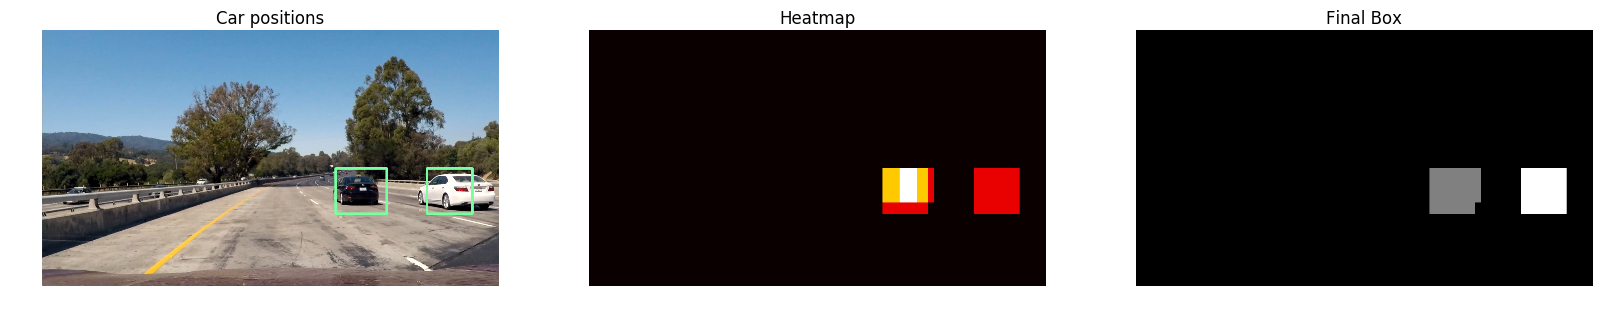

In [24]:
hot_windows = joblib.load("hot_windows.pkl","wb")

for file in glob.glob('test_images/test1.jpg'):
    image = mpimg.imread(file)
   
    heat = np.zeros_like(image[:,:,0]).astype(np.float)

    # Add heat to each window in windows list
    heat = add_heat(heat,hot_windows) 

    # Apply threshold to help remove false positives
    heat = apply_threshold(heat,0)

    # Visualize the heatmap when displaying    
    heatmap = np.clip(heat,0, 255)

    # Find final boxes from heatmap using label function
    labels = label(heatmap)
    draw_img = draw_labeled_bboxes(np.copy(image), labels)
     
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20,10))
    draw_img = ax1.imshow(draw_img)
    heatmap = ax2.imshow(heatmap,cmap='hot')
    final_Box = ax3.imshow(labels[0], cmap='gray')
    ax1.set_title('Car positions')
    ax2.set_title('Heatmap')
    ax3.set_title('Final Box')
    ax1.axis('off')
    ax2.axis('off')
    ax3.axis('off')


# Video pipeline 

In [27]:
### Video pipeline
def video_pipeline(image):
    windows = []
    for i in range(len(xy_windows)):
        windows += slide_window(image, x_start_stop=x_start_stop, y_start_stop=y_start_stop, 
                    xy_window=xy_windows[i], xy_overlap=(0.50, 0.50))  
    hot_windows = search_windows(image, windows, clf, X_scaler, color_space=color_space, 
                                spatial_size=spatial_size, hist_bins=hist_bins, 
                                orient=orient, pix_per_cell=pix_per_cell, 
                                cell_per_block=cell_per_block, 
                                hog_channel=hog_channel, spatial_feat=spatial_feat, 
                                hist_feat=hist_feat, hog_feat=hog_feat) 
    
    # Create heatmap
    heat_new = np.zeros_like(image[:,:,1]).astype(np.float)
    heat = add_heat(heat_new,hot_windows) #add more heat to the original heatmap
    apply_threshold(heat,0) 
    labels = label(heat)
#     print(labels[1], 'cars found')
    # Draw bounding boxes on the image
    result = draw_labeled_bboxes(image, labels)
    return result

# Use video pipeline function to test images in the `test_images` directory

2 cars found
0 cars found
1 cars found
2 cars found
2 cars found
2 cars found


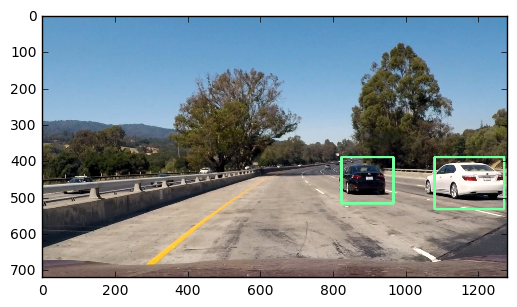

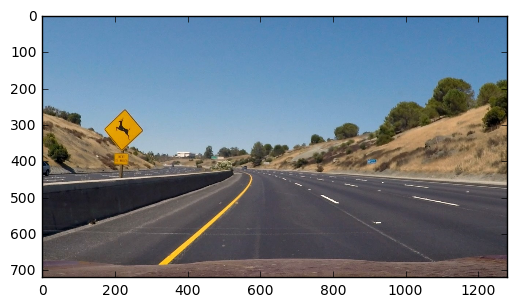

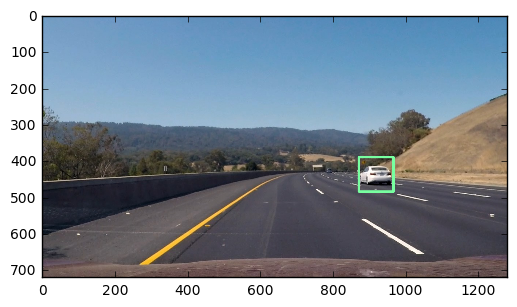

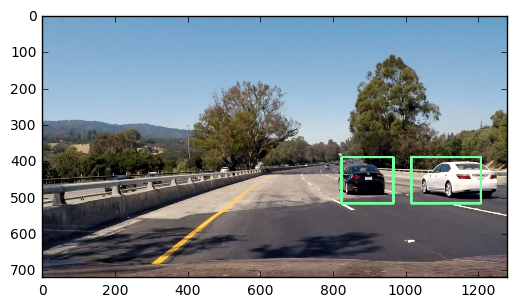

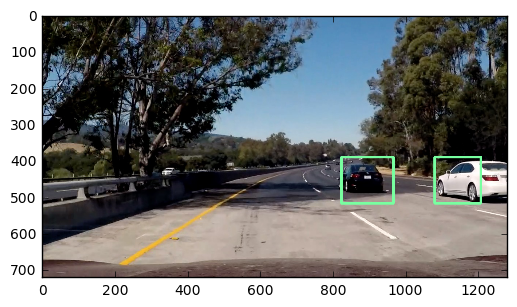

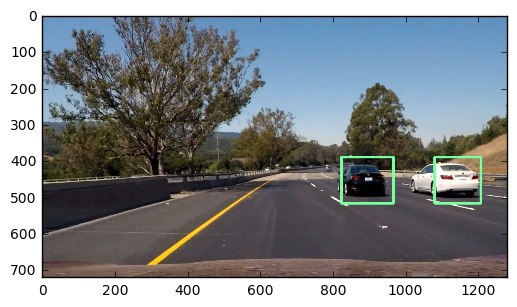

In [26]:
hot_windows = joblib.load("hot_windows.pkl","wb")

for file in glob.glob('test_images/*'):
    image = mpimg.imread(file, format='PNG')
    plt.subplots(1,1, figsize=(6,6))
    plt.imshow(video_pipeline(image))
    # Save images
    plt.savefig('output_images/video_pipleine_1.png') 

# Test Video

In [28]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML

clf = joblib.load("svc_model.pkl")
xy_windows =[(128,128),(96,96)]    
xy_overlaps = [(0.5,0.5)] 
y_start_stop = [390,600]
x_start_stop = [630,1280]

video = VideoFileClip("test_video.mp4")
video_output = "test_video_1.mp4"
project_clip = video.fl_image(video_pipeline) #NOTE: this function expects color images!!
%time project_clip.write_videofile(video_output, audio=False)

[MoviePy] >>>> Building video test_video_1.mp4
[MoviePy] Writing video test_video_1.mp4


 97%|████████████████████████████████████████▉ | 38/39 [00:09<00:00,  3.86it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_video_1.mp4 

Wall time: 10.5 s


# Project Video

In [29]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML

clf = joblib.load("svc_model.pkl")
xy_windows =[(128,128),(96,96)]    
xy_overlaps = [(0.5,0.5)]
y_start_stop = [390,600]
x_start_stop = [630,1280]

video = VideoFileClip("project_video.mp4")  #.subclip(30,35)
video_output = "project_video_1.mp4"
project_clip = video.fl_image(video_pipeline) #NOTE: this function expects color images!!
%time project_clip.write_videofile(video_output, audio=False)

[MoviePy] >>>> Building video project_video_1.mp4
[MoviePy] Writing video project_video_1.mp4


100%|█████████████████████████████████████▉| 1260/1261 [05:21<00:00,  3.88it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_1.mp4 

Wall time: 5min 21s


# Keras model (Optional Implementation)

In [ ]:
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.layers.normalization import BatchNormalization
from keras.optimizers import Adam
from keras.layers import Convolution2D, MaxPooling2D, ZeroPadding2D,Lambda
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
import json
from keras.wrappers.scikit_learn import KerasClassifier
from keras.layers import ELU

learning_rate = .001

feature_length = 17676


def vehicle_model():
    model = Sequential()
    # 5 fully connected layers
    model.add(Dense(50,input_dim=feature_length))
    model.add(ELU())
    model.add(Dropout(.40))
    
    model.add(Dense(100))
    model.add(ELU())
    model.add(Dropout(.40))
    
    
    model.add(Dense(50))
    model.add(ELU())
    model.add(Dropout(.40))
    
    model.add(Dense(10))
    model.add(ELU())
    model.add(Dropout(.40))
    
    model.add(Dense(1))
    model.add(Activation('sigmoid'))
        
    model.summary()
    return model
